<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Reviewers comment v1</h1>

Hello Jimmy!

I'm happy to review your project today 🙌

My name is **Justino Imbert** ([this](https://hub.tripleten.com/u/125e88ae) is my Hub profile) and today I'll be reviewing your project!


You can find my comments under the heading **«Review»**. I will categorize my comments in green, yellow, red or blue boxes like this:

<div class="alert alert-success">
    <b>Success:</b> if everything is done successfully
</div>
<div class="alert alert-warning">
    <b>Remarks:</b> if I can give some recommendations or ways to improve the project
</div>
<div class="alert alert-danger">
    <b>Needs fixing:</b> if the block requires some corrections. Work cant be accepted with the red comments
</div>

Please dont remove my comments :) If you have any questions dont hesitate to respond to my comments in a different section. 
<div class="alert alert-info"> <b>Student comments:</b> For example like this</div>    

<div class="alert alert-block alert-info">
<b>Reviewer's comment v1:</b> </a>
    
Amazing job with this submission! I really loved your project. 

It’s clear you put a lot of thought and effort into it. Everything is well structured, and your analysis is strong and insightful. 

I’m approving this project!

Best of luck in your next sprints. 

Keep up this excellent work!
    
</div>

# 1. Prepare the data

### Project Overfiew
The goal of this project is to deveop a ML model to predict the recovery rates of gold from a mineral processing plant. Specifically, we aim to predict two key target variables:
 - `rougher.output.recovery`
 - `final.output.recovery`

We will:
- preare and explore the data for train, test and full data
- calculate the recovery for `rougher.output.recovery`
- Perform data preprocessing for the missing values for `features` and `targets`
- Explore and visualize the data to identify patterns, trends, and outliers
- Preprocess missing values in both `features` and `target`
- Train multiple models (RandomForest, Gradient Boosting, and Linear Regression) and evaluate them using cross-validation
- Select the best model using custom sMAPE and R² metrics
- Test the model on a realistic test set using only available features

Let's began by loading and inspecting the data

    

In [1]:
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import ks_2samp
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.multioutput import MultiOutputRegressor

## 1.1 Open the files and look into the data

In [2]:
train = pd.read_csv('/datasets/gold_recovery_train.csv')
test = pd.read_csv('/datasets/gold_recovery_test.csv')
gold = pd.read_csv('/datasets/gold_recovery_full.csv')

In [3]:
train.shape

(16860, 87)

In [4]:
test.shape

(5856, 53)

In [5]:
gold.shape

(22716, 87)

<b> we can see that this is a 75:25% test split

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

In [8]:
gold.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


## 1.2 Check to see if recovery is calculated correctly

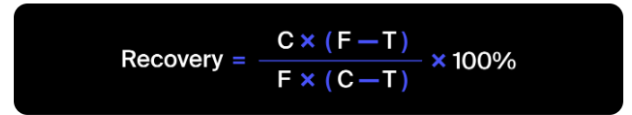

### To calculate the Recovery function from the picture above where: 
 - C = rougher.output.concentrate_au
 - F = rougher.input.feed_au
 - T = rougher.output.tail.au

In [9]:
# Calculate recovery using the formula
c = train['rougher.output.concentrate_au']
f = train['rougher.input.feed_au']
t = train['rougher.output.tail_au']

# calculate recovery 
recovery = ((c*(f - t)) / (f * (c - t))) * 100

# print each constant variable for the first row to verify that it is correct. 
print(f"C = {c.head(1)}")
print(f"F = {f.head(1)}")
print(f"T = {t.head(1)}")

C = 0    19.793808
Name: rougher.output.concentrate_au, dtype: float64
F = 0    6.48615
Name: rougher.input.feed_au, dtype: float64
T = 0    1.170244
Name: rougher.output.tail_au, dtype: float64


To verify that the recovery is calculated let's calculate the recovery for the first line of data: 
---
19.793808 x (6.48615 - 1.170244) / 6.48615 x (19.793808 - 1.170244) x 100  
19.793808 x (5.315906) / 6.48615 x (18.623564)  
105.222022710048 / 120.7952296386  
0.871077632989775 x 100  
87.1077632989775

let's look at the recovery output and verify that the first line is correct. 

<div class="alert alert-block alert-success">
<b>Reviewer's comment v1:</b> </a>

Awesome job!
    
</div>

In [10]:
# print the recovery results
print(recovery)

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
16855    89.574376
16856    87.724007
16857    88.890579
16858    89.858126
16859    89.514960
Length: 16860, dtype: float64


Perfect! We put in the formula correctly! 

In [11]:
# Check for NaN values in our inputs
print("NaN counts:")
print(f"C (concentrate): {train['rougher.output.concentrate_au'].isna().sum()}")
print(f"F (feed): {train['rougher.input.feed_au'].isna().sum()}")
print(f"T (tail): {train['rougher.output.tail_au'].isna().sum()}")

# Check for infinite values in your recovery calculation
print(f"\nInfinite values in recovery: {np.isinf(recovery).sum()}")
print(f"NaN values in recovery: {recovery.isna().sum()}")

NaN counts:
C (concentrate): 82
F (feed): 83
T (tail): 2249

Infinite values in recovery: 30
NaN values in recovery: 2283


<b>Okay, so we do have quite a significant amount of NaNs for the train data and the recovery data. We should drop the errors so we can find the MAE between my calculations and the feature values. 

In [12]:
# Create a mask for valid (non-NaN) values in all required columns
valid_mask = (
    train['rougher.output.concentrate_au'].notna() & 
    train['rougher.input.feed_au'].notna() & 
    train['rougher.output.tail_au'].notna() &
    train['rougher.output.recovery'].notna() &
    (train['rougher.output.concentrate_au'] > train['rougher.output.tail_au'])
)

print(f"Valid rows for comparison: {valid_mask.sum()} out of {len(train)}")

# Calculate recovery only for valid rows
C_clean = train.loc[valid_mask, 'rougher.output.concentrate_au']
F_clean = train.loc[valid_mask, 'rougher.input.feed_au'] 
T_clean = train.loc[valid_mask, 'rougher.output.tail_au']

recovery_clean = (C_clean * (F_clean - T_clean)) / (F_clean * (C_clean - T_clean)) * 100
existing_recovery_clean = train.loc[valid_mask, 'rougher.output.recovery']

# Calculate MAE
mae = mean_absolute_error(existing_recovery_clean, recovery_clean)
print(f"MAE between calculated and existing recovery: {mae}")

Valid rows for comparison: 13958 out of 16860
MAE between calculated and existing recovery: 9.521065218173147e-15


In [13]:
# Check for any problematic values
print("Checking for potential issues:")
print(f"any C = 0 cases: {(C_clean == 0).sum()}")
print(f"Any C = T cases: {(C_clean == T_clean).sum()}")
print(f"Any C < T cases: {(C_clean < T_clean).sum()}")
print(f"Recovery range - calculated: {recovery_clean.min():.6f} to {recovery_clean.max():.6f}")
print(f"Recovery range - existing: {existing_recovery_clean.min():.6f} to {existing_recovery_clean.max():.6f}")

Checking for potential issues:
any C = 0 cases: 0
Any C = T cases: 0
Any C < T cases: 0
Recovery range - calculated: 1.412748 to 99.979041
Recovery range - existing: 1.412748 to 99.979041


#### Few key things to note:
 - we got rid of the potential issues, from the recovery formula, when C equals to 0, we have undefined result because we can't have 0 in the denominator
 - We don't have any scenarios where C < 0 where it would had caused a negative or undefined results
 - We have 13958 out of 16860 rows; we are able to use 82.79% of the data from the trainnig dataset.
 - Lastly, we see that `MSE` is 0 and the calculated and existing recovery range are the exact same range. 

<div class="alert alert-block alert-success">
<b>Reviewer's comment v1:</b> </a>

Amazing job!
    
</div>

## 1.3 Analyze the features not available in the test set.

In [14]:
# Compare column sets
train_columns = set(train.columns)
test_columns = set(test.columns)

# Find features present in training but missing in test
missing_in_test = train_columns - test_columns
print(f"Features in training but NOT in test: {len(missing_in_test)}")
print("Missing features:")
for feature in sorted(missing_in_test):
    print(f"  - {feature}")

Features in training but NOT in test: 34
Missing features:
  - final.output.concentrate_ag
  - final.output.concentrate_au
  - final.output.concentrate_pb
  - final.output.concentrate_sol
  - final.output.recovery
  - final.output.tail_ag
  - final.output.tail_au
  - final.output.tail_pb
  - final.output.tail_sol
  - primary_cleaner.output.concentrate_ag
  - primary_cleaner.output.concentrate_au
  - primary_cleaner.output.concentrate_pb
  - primary_cleaner.output.concentrate_sol
  - primary_cleaner.output.tail_ag
  - primary_cleaner.output.tail_au
  - primary_cleaner.output.tail_pb
  - primary_cleaner.output.tail_sol
  - rougher.calculation.au_pb_ratio
  - rougher.calculation.floatbank10_sulfate_to_au_feed
  - rougher.calculation.floatbank11_sulfate_to_au_feed
  - rougher.calculation.sulfate_to_au_concentrate
  - rougher.output.concentrate_ag
  - rougher.output.concentrate_au
  - rougher.output.concentrate_pb
  - rougher.output.concentrate_sol
  - rougher.output.recovery
  - rougher.ou

In [15]:

# Let's categorize the missing features
missing_features = [
    'final.output.concentrate_ag', 'final.output.concentrate_au', 'final.output.concentrate_pb', 
    'final.output.concentrate_sol', 'final.output.recovery', 'final.output.tail_ag', 
    'final.output.tail_au', 'final.output.tail_pb', 'final.output.tail_sol',
    'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_au', 
    'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol',
    'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_au', 
    'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol',
    'rougher.calculation.au_pb_ratio', 'rougher.calculation.floatbank10_sulfate_to_au_feed',
    'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.calculation.sulfate_to_au_concentrate',
    'rougher.output.concentrate_ag', 'rougher.output.concentrate_au', 'rougher.output.concentrate_pb',
    'rougher.output.concentrate_sol', 'rougher.output.recovery', 'rougher.output.tail_ag',
    'rougher.output.tail_au', 'rougher.output.tail_pb', 'rougher.output.tail_sol',
    'secondary_cleaner.output.tail_ag', 'secondary_cleaner.output.tail_au',
    'secondary_cleaner.output.tail_pb', 'secondary_cleaner.output.tail_sol'
]

# Categorize by stage and type
categories = {
    'final_outputs': [],
    'rougher_outputs': [],
    'primary_cleaner_outputs': [],
    'secondary_cleaner_outputs': [],
    'calculated_parameters': []
}

for feature in missing_features:
    if 'final.output' in feature:
        categories['final_outputs'].append(feature)
    elif 'rougher.output' in feature:
        categories['rougher_outputs'].append(feature)
    elif 'primary_cleaner.output' in feature:
        categories['primary_cleaner_outputs'].append(feature)
    elif 'secondary_cleaner.output' in feature:
        categories['secondary_cleaner_outputs'].append(feature)
    elif 'calculation' in feature:
        categories['calculated_parameters'].append(feature)

# Print categorization
for category, features in categories.items():
    print(f"\n{category.upper().replace('_', ' ')}: {len(features)} features")
    for feature in features:
        print(f"  - {feature}")



FINAL OUTPUTS: 9 features
  - final.output.concentrate_ag
  - final.output.concentrate_au
  - final.output.concentrate_pb
  - final.output.concentrate_sol
  - final.output.recovery
  - final.output.tail_ag
  - final.output.tail_au
  - final.output.tail_pb
  - final.output.tail_sol

ROUGHER OUTPUTS: 9 features
  - rougher.output.concentrate_ag
  - rougher.output.concentrate_au
  - rougher.output.concentrate_pb
  - rougher.output.concentrate_sol
  - rougher.output.recovery
  - rougher.output.tail_ag
  - rougher.output.tail_au
  - rougher.output.tail_pb
  - rougher.output.tail_sol

PRIMARY CLEANER OUTPUTS: 8 features
  - primary_cleaner.output.concentrate_ag
  - primary_cleaner.output.concentrate_au
  - primary_cleaner.output.concentrate_pb
  - primary_cleaner.output.concentrate_sol
  - primary_cleaner.output.tail_ag
  - primary_cleaner.output.tail_au
  - primary_cleaner.output.tail_pb
  - primary_cleaner.output.tail_sol

SECONDARY CLEANER OUTPUTS: 4 features
  - secondary_cleaner.output

### What are these parameters? What is their type?

---
The missing fesatures represent **output and results**. In order to make predictions, you wouldn't have access to the final results because that's the whole purpose of predicting!  

---

From looking at the missing columns we have: 
 - **9** missing features of `final.output`
 - **9** missing features of `rougher.output`
 - **8** missing features of `primary_cleaner.output`
 - **4** missing features of `secondary_cleaner.output`
 - **4** missing features of `rougher.calculations`

<div class="alert alert-block alert-success">
<b>Reviewer's comment v1:</b> </a>

Excellent work!!
    
</div>

## 1.4 Perform data preprocessing

In [16]:

features = train.drop(['rougher.output.recovery', 'final.output.recovery','date'], axis=1)
targets = train[['rougher.output.recovery', 'final.output.recovery']]


Let's start exploring missing values in the features and targets

In [17]:
# Check missing values in features
print("Missing values in features:")
missing_counts = features.isnull().sum()
missing_percentages = (missing_counts / len(features)) * 100

# Show columns with missing values
missing_info = pd.DataFrame({
    'Missing_Count': missing_counts,
    'Missing_Percentage': missing_percentages
}).sort_values('Missing_Count', ascending=False)

print(missing_info[missing_info['Missing_Count'] > 0])

# Check missing values in targets
print("\nMissing values in targets:")
print(targets.isnull().sum())

Missing values in features:
                                                    Missing_Count  \
rougher.output.tail_ag                                       2250   
rougher.output.tail_sol                                      2249   
rougher.output.tail_au                                       2249   
secondary_cleaner.output.tail_sol                            1986   
rougher.input.floatbank11_xanthate                           1904   
...                                                           ...   
primary_cleaner.state.floatbank8_b_level                       27   
primary_cleaner.state.floatbank8_c_level                       27   
primary_cleaner.state.floatbank8_d_level                       27   
rougher.calculation.sulfate_to_au_concentrate                  27   
rougher.calculation.floatbank10_sulfate_to_au_feed             27   

                                                    Missing_Percentage  
rougher.output.tail_ag                                       13.345196

### there are quite significant amount of data we're missing from the output field for both features and targets
For `features`, the missing values we have are: 
 - **13.35%** `rougher.output.tail_ag`
 - **13.34%** `rougher.output.tail_sol`
 - **13.34%** `rougher.output.tail_au`
 - **11.78%** `secondary_cleaner.output.tail_sol`
 - **11.29%** `rougher.input.floatbank11_xanthate`

---

For `targets`, the missing values we have are: 
 - **2573**: **15.26%** `rougher.output.recovery`
 - **1521**: **9.02%** `final.output.recovery`

How should we decide to deal with the missing values from `targets`? Let's find out how many missing values we would miss overall for `target`

In [18]:
# Check how many rows have at least one missing target
rows_with_any_missing_target = targets.isnull().any(axis=1).sum()
print(f"Rows with ANY missing target: {rows_with_any_missing_target}")

Rows with ANY missing target: 2711


In [19]:
# Check how many rows have both targets missing
rows_with_both_missing_targets = targets.isnull().all(axis=1).sum()
print(f"Rows with BOTH targets missing: {rows_with_both_missing_targets}")

Rows with BOTH targets missing: 1383


In [20]:
# See the overlap between missing targets
print("Missing target overlap:")
print(f"Missing rougher only: {targets['rougher.output.recovery'].isnull().sum()}")
print(f"Missing final only: {targets['final.output.recovery'].isnull().sum()}")
print(f"Missing both: {targets.isnull().all(axis=1).sum()}")

Missing target overlap:
Missing rougher only: 2573
Missing final only: 1521
Missing both: 1383


Let's use the dropna() to deal with the missing values

In [21]:
# Exclude rows with missing targets first
valid_targets_mask = ~targets.isnull().all(axis=1)
train_clean = train[valid_targets_mask]

# Then handle missing features with imputation or other methods
train_clean.shape

print(train_clean.isna().sum())

date                                            0
final.output.concentrate_ag                     5
final.output.concentrate_pb                     5
final.output.concentrate_sol                  288
final.output.concentrate_au                     4
                                             ... 
secondary_cleaner.state.floatbank5_a_level      1
secondary_cleaner.state.floatbank5_b_air        1
secondary_cleaner.state.floatbank5_b_level      1
secondary_cleaner.state.floatbank6_a_air        4
secondary_cleaner.state.floatbank6_a_level      1
Length: 87, dtype: int64


Before we predict the model, let's see both `features` and `targets` are the same shape. 

In [23]:
# First, get the indices of rows without missing values in features
features_clean = features.dropna()

# Then get the corresponding targets for those same rows
targets_clean = targets.dropna()

print(f"features_clean shape: {features_clean.shape}")
print(f"targets_clean shape: {targets_clean.shape}")
print(f"Do they have the same indices? {features_clean.index.equals(targets_clean.index)}")



features_clean shape: (11202, 84)
targets_clean shape: (14149, 2)
Do they have the same indices? False


We see that they're not the same shape, we need to make it the same shape before predicting the model

In [24]:
# Find rows that are complete in BOTH features AND targets
complete_mask = features.notna().all(axis=1) & targets.notna().all(axis=1)

# Apply the same mask to both
features_clean = features[complete_mask]
targets_clean = targets[complete_mask]


# Verify they match
print(f"features_clean shape: {features_clean.shape}")
print(f"targets_clean shape: {targets_clean.shape}")
print(f"Same indices? {features_clean.index.equals(targets_clean.index)}")


features_clean shape: (11017, 84)
targets_clean shape: (11017, 2)
Same indices? True


Let's do the final steps of preprocessing! Let's start with double checking to see if there's any missing values

In [25]:
# Check for any remaining missing values
print("Missing values in features:")
print(features_clean.isnull().sum().sum())
print("Missing values in targets:")
print(targets_clean.isnull().sum().sum())

Missing values in features:
0
Missing values in targets:
0


<b> Data types

In [26]:
# Check data types
print(features_clean.dtypes)
print(targets_clean.dtypes)

final.output.concentrate_ag                   float64
final.output.concentrate_pb                   float64
final.output.concentrate_sol                  float64
final.output.concentrate_au                   float64
final.output.tail_ag                          float64
                                               ...   
secondary_cleaner.state.floatbank5_a_level    float64
secondary_cleaner.state.floatbank5_b_air      float64
secondary_cleaner.state.floatbank5_b_level    float64
secondary_cleaner.state.floatbank6_a_air      float64
secondary_cleaner.state.floatbank6_a_level    float64
Length: 84, dtype: object
rougher.output.recovery    float64
final.output.recovery      float64
dtype: object


<b> Basis Statistics

In [27]:
# Look for any obvious outliers or weird values
print(features_clean.describe())
print(targets_clean.describe())

       final.output.concentrate_ag  final.output.concentrate_pb  \
count                 11017.000000                 11017.000000   
mean                      5.156333                    10.172687   
std                       1.340491                     1.589666   
min                       0.000000                     0.000000   
25%                       4.231103                     9.279625   
50%                       4.999314                    10.347530   
75%                       5.852710                    11.187018   
max                      16.001945                    17.031899   

       final.output.concentrate_sol  final.output.concentrate_au  \
count                  11017.000000                 11017.000000   
mean                       9.600570                    44.131636   
std                        2.842305                     4.171270   
min                        0.000000                     0.000000   
25%                        7.951464                    4

I noticed negative values ai all `floatbank_a_levels`, let's go investigate this

In [28]:
# Check how many negative values you have
negative_count = (features_clean['secondary_cleaner.state.floatbank5_a_level'] < 0).sum()
print(f"Number of negative values: {negative_count}")
print(f"Percentage: {negative_count/len(features_clean)*100:.2f}%")

Number of negative values: 11017
Percentage: 100.00%


In [29]:
# Check all level measurements
level_columns = [col for col in features_clean.columns if 'level' in col]
for col in level_columns:
    negative_pct = (features_clean[col] < 0).sum() / len(features_clean) * 100
    print(f"{col}: {negative_pct:.1f}% negative values")

primary_cleaner.state.floatbank8_a_level: 100.0% negative values
primary_cleaner.state.floatbank8_b_level: 100.0% negative values
primary_cleaner.state.floatbank8_c_level: 100.0% negative values
primary_cleaner.state.floatbank8_d_level: 100.0% negative values
rougher.state.floatbank10_a_level: 100.0% negative values
rougher.state.floatbank10_b_level: 100.0% negative values
rougher.state.floatbank10_c_level: 100.0% negative values
rougher.state.floatbank10_d_level: 100.0% negative values
rougher.state.floatbank10_e_level: 100.0% negative values
rougher.state.floatbank10_f_level: 100.0% negative values
secondary_cleaner.state.floatbank2_a_level: 100.0% negative values
secondary_cleaner.state.floatbank2_b_level: 100.0% negative values
secondary_cleaner.state.floatbank3_a_level: 100.0% negative values
secondary_cleaner.state.floatbank3_b_level: 100.0% negative values
secondary_cleaner.state.floatbank4_a_level: 100.0% negative values
secondary_cleaner.state.floatbank4_b_level: 100.0% negati

Ok so this is good news! 

---

<b>Why?</b>
 - Reference points set above the actual operating levels
 - Measurements taken as "depth below surface"
 - Pressure readings relative to atmospheric pressure

---

This is completely normal for this type of industrial process

Now let's graph the box plots to see if there's outliers! 

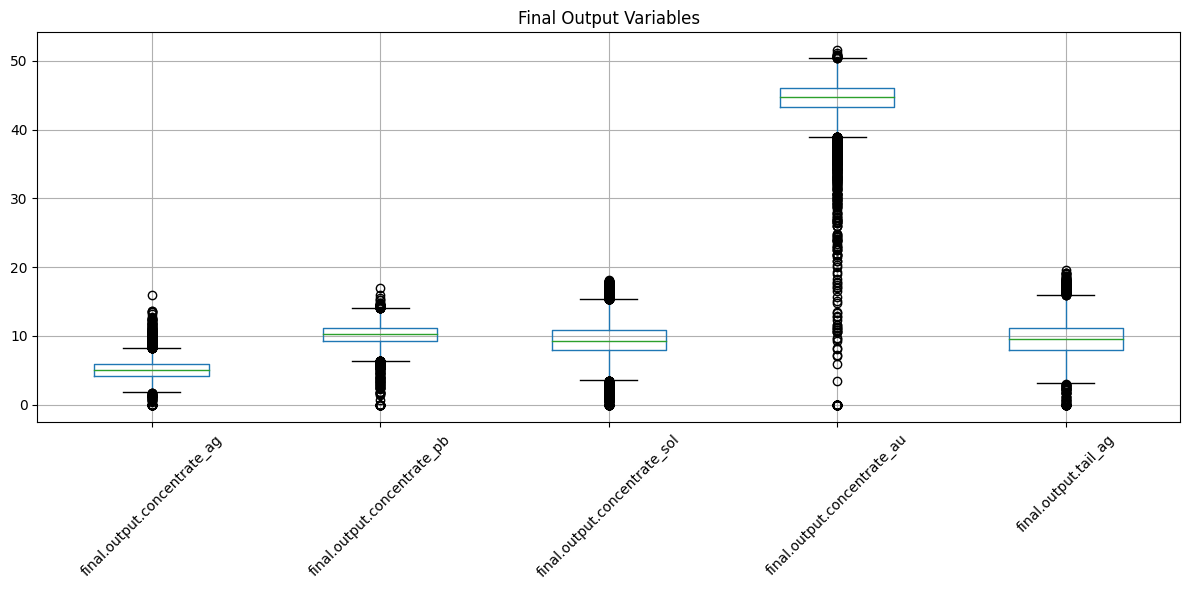

In [30]:
# Box plot for different process stages
primary_cols = [col for col in features_clean.columns if 'final.output' in col][:5]
plt.figure(figsize=(12, 6))
features_clean[primary_cols].boxplot()
plt.title('Final Output Variables')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [31]:
# Check the extreme outliers
au_outliers = features_clean['final.output.concentrate_au']
print(f"Values below 10%: {(au_outliers < 10).sum()}")
print(f"Values above 50%: {(au_outliers > 50).sum()}")
print(f"Minimum value: {au_outliers.min():.2f}%")
print(f"Maximum value: {au_outliers.max():.2f}%")

Values below 10%: 38
Values above 50%: 35
Minimum value: 0.00%
Maximum value: 51.57%


In [32]:
high_values = (features_clean['final.output.concentrate_au'] > 50).sum()
total_values = len(features_clean)
percentage = (high_values / total_values) * 100
print(f"Values above 50%: {high_values} ({percentage:.2f}%)")

Values above 50%: 35 (0.32%)


The outliers for final.output may seem overwhelming but, this is normal and only 32% are values above 50%, this won't significantly skew your model training. In fact, it might help your model learn to handle edge cases. 

Since the other final.output columns has the same pattern of skews, they likely represent real process events rather than measurement errors. 

Industrial Process reality: Gold processing plants naturally have variability due to: 
 - raw ore quality changes
 - Equipment performance variations
 - Operational adjustments
 - Process optimization attempts

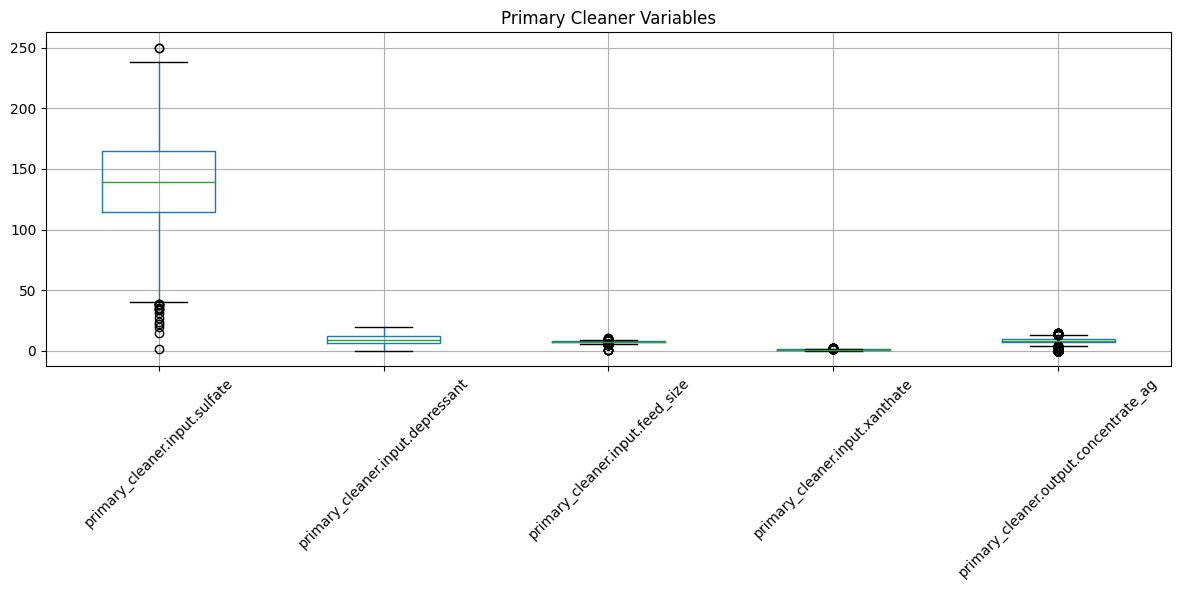

In [33]:
# Box plot for different process stages
primary_cols = [col for col in features_clean.columns if 'primary_cleaner' in col][:5]
plt.figure(figsize=(12, 6))
features_clean[primary_cols].boxplot()
plt.title('Primary Cleaner Variables')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-success">
<b>Reviewer's comment v1:</b> </a>

Great way to show the data! It really helps visualize the results.
    
</div>

In [34]:
# Check the extreme outliers for Premier Cleaners
primary_outliers = features_clean['primary_cleaner.input.sulfate']
print(f"Values below 10%: {(primary_outliers < 10).sum()}")
print(f"Values above 50%: {(primary_outliers > 50).sum()}")
print(f"Minimum value: {primary_outliers.min():.2f}%")
print(f"Maximum value: {primary_outliers.max():.2f}%")

Values below 10%: 1
Values above 50%: 10983
Minimum value: 1.87%
Maximum value: 250.13%


In [35]:
# Let's examine the distribution more carefully
print("Sulfate distribution:")
print(f"Mean: {primary_outliers.mean():.2f}")
print(f"Median: {primary_outliers.median():.2f}")
print(f"Standard deviation: {primary_outliers.std():.2f}")

# Look at percentiles
print("\nPercentiles:")
for p in [1, 5, 10, 25, 50, 75, 90, 95, 99]:
    print(f"{p}th percentile: {primary_outliers.quantile(p/100):.2f}")

Sulfate distribution:
Mean: 140.42
Median: 138.95
Standard deviation: 36.24

Percentiles:
1th percentile: 65.06
5th percentile: 83.03
10th percentile: 93.78
25th percentile: 114.76
50th percentile: 138.95
75th percentile: 164.76
90th percentile: 190.12
95th percentile: 204.77
99th percentile: 222.24


In [36]:
prime_high_values = (features_clean['primary_cleaner.input.sulfate'] > 50).sum()
prime_total_values = len(features_clean)
prime_percentage = (prime_high_values / prime_total_values) * 100
print(f"Values above 50%: {prime_high_values} ({prime_percentage:.2f}%)")

Values above 50%: 10983 (99.69%)


Looking at the `primary_cleaner.inputs.sulfate` the outlier's highest value is at **250.13%**. That might seem pretty high but it had consistent distrubtion for the following reasons. 
 - `Mean`: **140.42%**
 - `Median`: **138.95%**
 - Values are clustered around **140%**, not scattered randomly
 - The 99th percentile **222.24%** isn't that far from the max **250.13%**

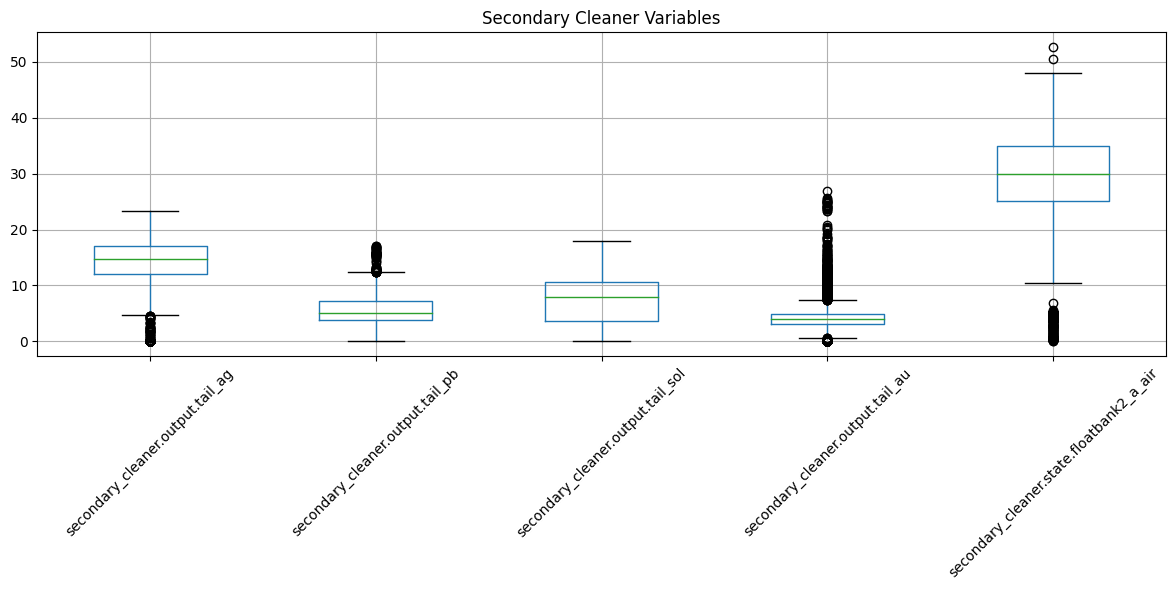

In [37]:
# Box plot for different process stages
primary_cols = [col for col in features_clean.columns if 'secondary_cleaner' in col][:5]
plt.figure(figsize=(12, 6))
features_clean[primary_cols].boxplot()
plt.title('Secondary Cleaner Variables')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [38]:
# Check the extreme outliers for Secondary Cleaners
secondary_outliers = features_clean['secondary_cleaner.state.floatbank2_a_air']
print(f"Values below 10%: {(secondary_outliers < 10).sum()}")
print(f"Values above 50%: {(secondary_outliers > 50).sum()}")
print(f"Minimum value: {secondary_outliers.min():.2f}%")
print(f"Maximum value: {secondary_outliers.max():.2f}%")

Values below 10%: 226
Values above 50%: 2
Minimum value: 0.12%
Maximum value: 52.65%


In [39]:
# Let's examine the distribution more carefully
print("air distribution:")
print(f"Mean: {secondary_outliers.mean():.2f}")
print(f"Median: {secondary_outliers.median():.2f}")
print(f"Standard deviation: {secondary_outliers.std():.2f}")

# Look at percentiles
print("\nPercentiles:")
for p in [1, 5, 10, 25, 50, 75, 90, 95, 99]:
    print(f"{p}th percentile: {secondary_outliers.quantile(p/100):.2f}")

air distribution:
Mean: 29.50
Median: 30.00
Standard deviation: 5.63

Percentiles:
1th percentile: 4.13
5th percentile: 24.89
10th percentile: 24.95
25th percentile: 25.08
50th percentile: 30.00
75th percentile: 34.90
90th percentile: 35.04
95th percentile: 35.09
99th percentile: 37.02


Looking at the outliers for the `Secondary` columns, we have normal distributions and don't see an extreme outlier where we need to fix before training the model. 

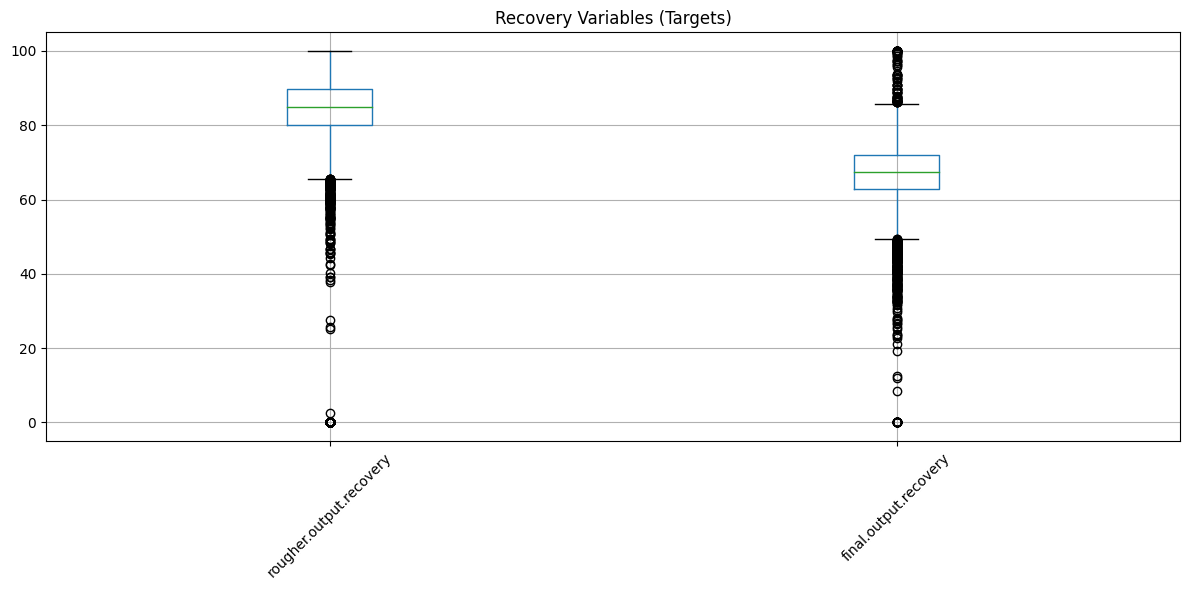

In [40]:
# Box plot for target variables (recovery)
plt.figure(figsize=(12, 6))
targets_clean.boxplot()
plt.title('Recovery Variables (Targets)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The outliers look like it's a same pattern of flow but before we got to Step 2, let's check for dupes

In [41]:
# Check for duplicates in your datasets
print("Checking for duplicates:")
print(f"Training set duplicates: {train.duplicated().sum()}")
print(f"Test set duplicates: {test.duplicated().sum()}")
print(f"Full dataset duplicates: {gold.duplicated().sum()}")

# Let's also check the shape before and after removing duplicates
print(f"\nOriginal shapes:")
print(f"Training set: {train.shape}")
print(f"Test set: {test.shape}")
print(f"Full dataset: {gold.shape}")

Checking for duplicates:
Training set duplicates: 0
Test set duplicates: 0
Full dataset duplicates: 0

Original shapes:
Training set: (16860, 87)
Test set: (5856, 53)
Full dataset: (22716, 87)


Okay, there are no dupes! We are good to go for step 2!

<div class="alert alert-block alert-success">
<b>Reviewer's comment v1:</b> </a>

Very good work completing project instruction 1!
    
</div>

# 2. Analyze the data

## 2.1 Focusing on the concentrations of metals

In [42]:
stages = {
    'Raw Feed': 'rougher.input.feed',
    'Rougher Concentrate': 'rougher.output.concentrate',
    'Final Concentrate': 'final.output.concentrate'
}
metals = ['au', 'ag', 'pb']

conc_df = pd.DataFrame(index=stages.keys(), columns=metals)
for metal in metals:
    for stage_name, stage_prefix in stages.items():
        col_name = f"{stage_prefix}_{metal}"
        if col_name in features_clean.columns:
            conc_df.loc[stage_name, metal] = features_clean[col_name].mean()

print("Average Metal Concentrations by Stage:")
print(conc_df.astype(float).round(2))

Average Metal Concentrations by Stage:
                        au     ag     pb
Raw Feed              8.11   8.77   3.55
Rougher Concentrate  19.78  11.84   7.61
Final Concentrate    44.13   5.16  10.17


### Metal Concentration Findings
 - ***Gold (AU) - Progressive Concentratation:***
     - `Raw feed`: 8.11% → `Rougher`: 19.78%  → `Final`: 44.13%
     - This shows perfect purification - gold concentrates beautifully through each stage!
 - ***Silver (Ag) - Peak at Rougher:***
     - `Raw Feed`: 8.77% → `Rougher`: 11.84% → `Final`: 5.16%
     - Silver concentrates initially but then decreases in **final stages**
 - ***Lead (Pb) - Steady Increase:***
     -  Raw Feed: 3.55% → Rougher: 7.61% → Final: 10.17%
     -  Lead shows **consistent concentration** through both stages

<div class="alert alert-block alert-success">
<b>Reviewer's comment v1:</b> </a>

Great work here! You’re doing an excellent job.
    
</div>

## 2.2 Compare the feed particle size distributions in the training set and in the test set. 

**note**: <b>`If the distributions vary significantly, the model evaluatoin will be incorrect`</b>

Particle Size Distribution Comparison:
Train - Mean: 7.40, Std: 0.58
Test - Mean: 7.26, Std: 0.61


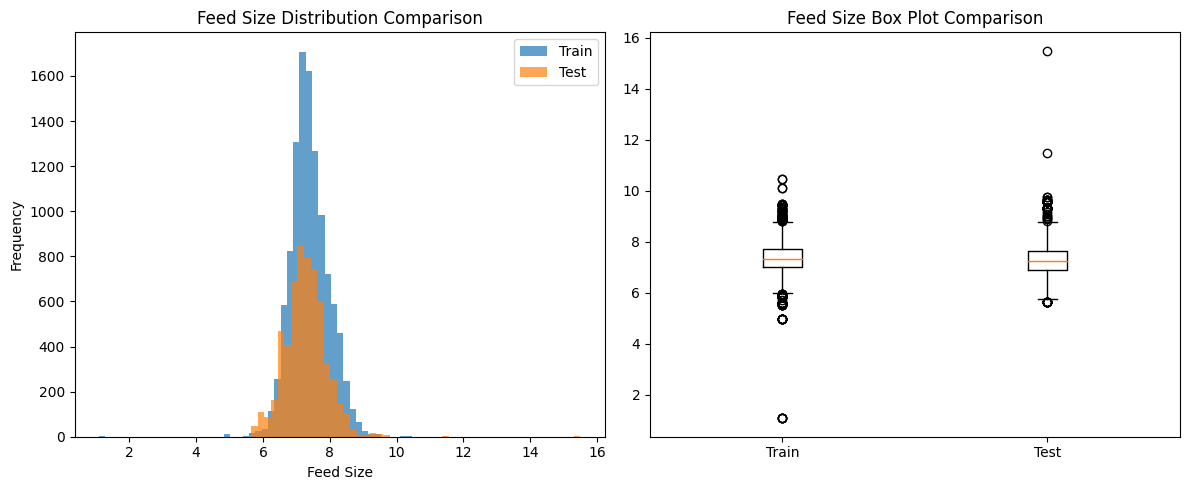

In [43]:
# Compare feed particle size distributions
train_particle_size = features_clean['primary_cleaner.input.feed_size']
test_particle_size = test['primary_cleaner.input.feed_size'].dropna()

print("Particle Size Distribution Comparison:")
print(f"Train - Mean: {train_particle_size.mean():.2f}, Std: {train_particle_size.std():.2f}")
print(f"Test - Mean: {test_particle_size.mean():.2f}, Std: {test_particle_size.std():.2f}")

# Create comparison plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(train_particle_size, bins=50, alpha=0.7, label='Train')
plt.hist(test_particle_size, bins=50, alpha=0.7, label='Test')
plt.xlabel('Feed Size')
plt.ylabel('Frequency')
plt.title('Feed Size Distribution Comparison')
plt.legend()

plt.subplot(1, 2, 2)
plt.boxplot([train_particle_size, test_particle_size], labels=['Train', 'Test'])
plt.title('Feed Size Box Plot Comparison')
plt.tight_layout()
plt.show()

In [44]:
# Perform statistical test for distribution similarity
statistic, p_value = stats.ks_2samp(train_particle_size, test_particle_size)
print(f"T-test results:")
print(f"Statistic: {statistic:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value > 0.05:
    print("✅ Distributions are NOT significantly different (good for model evaluation)")
else:
    print("⚠️ Distributions are significantly different")

T-test results:
Statistic: 0.0980
P-value: 0.0000
⚠️ Distributions are significantly different


<div class="alert alert-block alert-success">
<b>Reviewer's comment v1:</b> </a>

Excellent work in this part!
    
</div>

We see there are significant differences in our data by looking at our p-value. We need to consider some changes before building the model.

## 2.3  Consider the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate. 

### Data Preprocessing Options:
 - Normalization/Standardization: Scale features to reduce the impact of distribution differences
 - Feature Engineering: Create relative features that are less sensitive to absolute differences
 - Stratified Sampling: Ensure train/test splits are more representative

### Model Strategy Adjustments:
 - Cross-validation: Use time-aware or stratified CV instead of simple train/test split
 - Domain Adaptation: Techniques to handle distribution shift
 - Robust Models: Choose algorithms less sensitive to input distribution changes

### Validation Approach:
 - Multiple Evaluation Periods: Test on different time periods
 - Performance Monitoring: Track model performance over time

In [45]:
# Calculate the total concentrations at different stages

total_metals = ['au', 'ag', 'pb']
total_stages = {
    'Raw Feed': 'rougher.input.feed',
    'Rougher Concentrate': 'rougher.output.concentrate', 
    'Final Concentrate': 'final.output.concentrate'
}

# Define reusable helper function
def get_metal_columns(stage_prefix, metals=['au', 'ag', 'pb']):
    """Returns column names for given stage prefix and metal list."""
    return [f"{stage_prefix}_{metal}" for metal in metals]

# Calculate total metal concentration per stage
total_concentration = {}
for stage_name, stage_prefix in total_stages.items():
    metal_columns = get_metal_columns(stage_prefix)
    total_concentration[stage_name] = features_clean[metal_columns].sum().sum()

# Display results
concentration_df = pd.DataFrame(total_concentration, index=[0])
print(concentration_df.round(2))


    Raw Feed  Rougher Concentrate  Final Concentrate
0  225138.79            432208.94          655078.05


### From the breakdown: 
Looking at the total concentration for each stages, we see that `Rougher Concentrate` nearly doubles `Raw feed` and `Final Concentrate` nearly triples `Raw Feed`

---

### Things to consider: 
  1. Add more metal to the material, or
  2. Remove waste material while keeping the metals

Let's try to eliminate anomalies by removing waste material while keeping the metals. Let's start with checking for outliers in each stage

In [46]:
# Check for outliers in each stage

for stage_name, stage_prefix in total_stages.items():
    metal_columns = get_metal_columns(stage_prefix)
    row_totals = features_clean[metal_columns].sum(axis=1)
    
    print(f"\n{stage_name} - Row totals statistics:")
    print(f"Mean: {row_totals.mean():.2f}")
    print(f"Std: {row_totals.std():.2f}")
    print(f"Min: {row_totals.min():.2f}")
    print(f"Max: {row_totals.max():.2f}")



Raw Feed - Row totals statistics:
Mean: 20.44
Std: 4.31
Min: 0.03
Max: 32.84

Rougher Concentrate - Row totals statistics:
Mean: 39.23
Std: 6.63
Min: 0.00
Max: 49.70

Final Concentrate - Row totals statistics:
Mean: 59.46
Std: 4.71
Min: 0.00
Max: 64.86


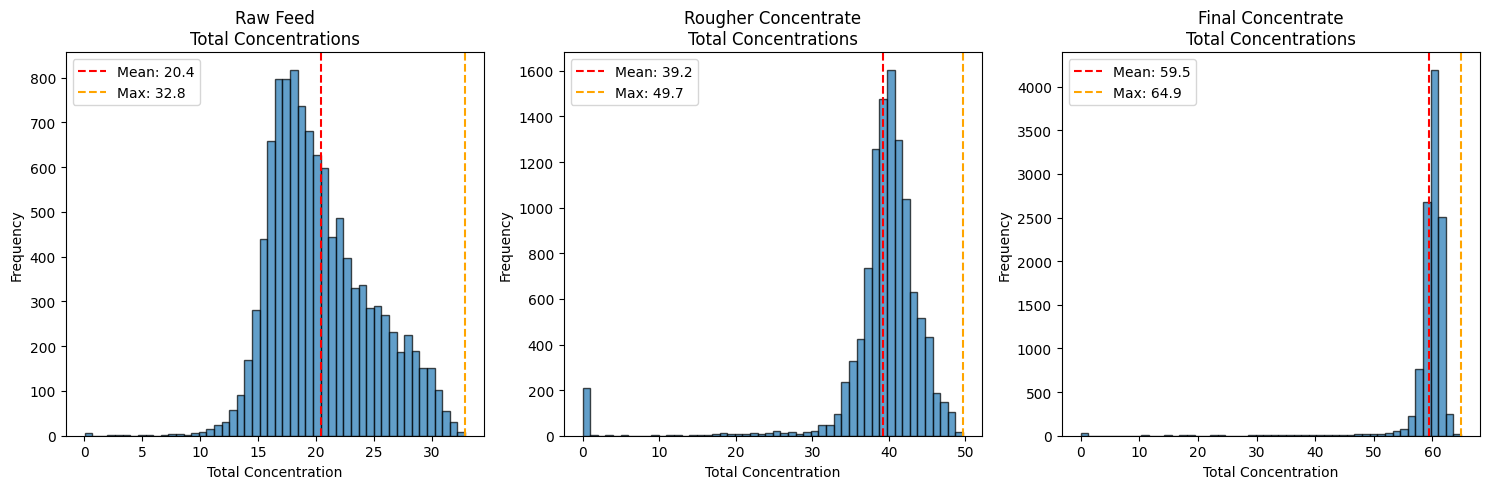

In [47]:
# Plot histograms of total concentration per stage

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (stage_name, stage_prefix) in enumerate(total_stages.items()):
    metal_columns = get_metal_columns(stage_prefix)
    row_totals = features_clean[metal_columns].sum(axis=1)
    
    axes[i].hist(row_totals, bins=50, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'{stage_name}\nTotal Concentrations')
    axes[i].set_xlabel('Total Concentration')
    axes[i].set_ylabel('Frequency')

    mean_val = row_totals.mean()
    max_val = row_totals.max()
    axes[i].axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.1f}')
    axes[i].axvline(max_val, color='orange', linestyle='--', label=f'Max: {max_val:.1f}')
    axes[i].legend()

plt.tight_layout()
plt.show()


### Summary of the Histogram: 
 - **Raw Feed:** Mean = 20.4, Max = 32.8 (relatively normal distribution)
 - **Rougher Concentrate:** Mean = 39.2, Max = 49.7 (Getting more left-skewed)
 - **Final Concentrate:** Mean = 59.5, Max = 64.9 (heavily left-skewed)

---

1. The distributions are getting more compressed
2. Most values cluster near the maximum
3. The "tail" is on the left

<div class="alert alert-block alert-success">
<b>Reviewer's comment v1:</b> </a>

Nice job!
    
</div>

In [48]:
# Calculate total concentrations for Raw Feed in test data
test_metals = ['au', 'ag', 'pb']
test_stage_prefix = 'rougher.input.feed'

# Calculate row totals for test data
test_metal_columns = [f"{test_stage_prefix}_{metal}" for metal in test_metals]
test_row_totals = test[test_metal_columns].sum(axis=1)

print("Test data - Raw Feed statistics:")
print(f"Mean: {test_row_totals.mean():.2f}")
print(f"Std: {test_row_totals.std():.2f}")
print(f"Min: {test_row_totals.min():.2f}")
print(f"Max: {test_row_totals.max():.2f}")

# Compare with training data Raw Feed
train_row_totals = features_clean[['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb']].sum(axis=1)

print("\nTraining data - Raw Feed statistics:")
print(f"Mean: {train_row_totals.mean():.2f}")
print(f"Std: {train_row_totals.std():.2f}")
print(f"Min: {train_row_totals.min():.2f}")
print(f"Max: {train_row_totals.max():.2f}")

Test data - Raw Feed statistics:
Mean: 20.93
Std: 6.92
Min: 0.00
Max: 33.50

Training data - Raw Feed statistics:
Mean: 20.44
Std: 4.31
Min: 0.03
Max: 32.84


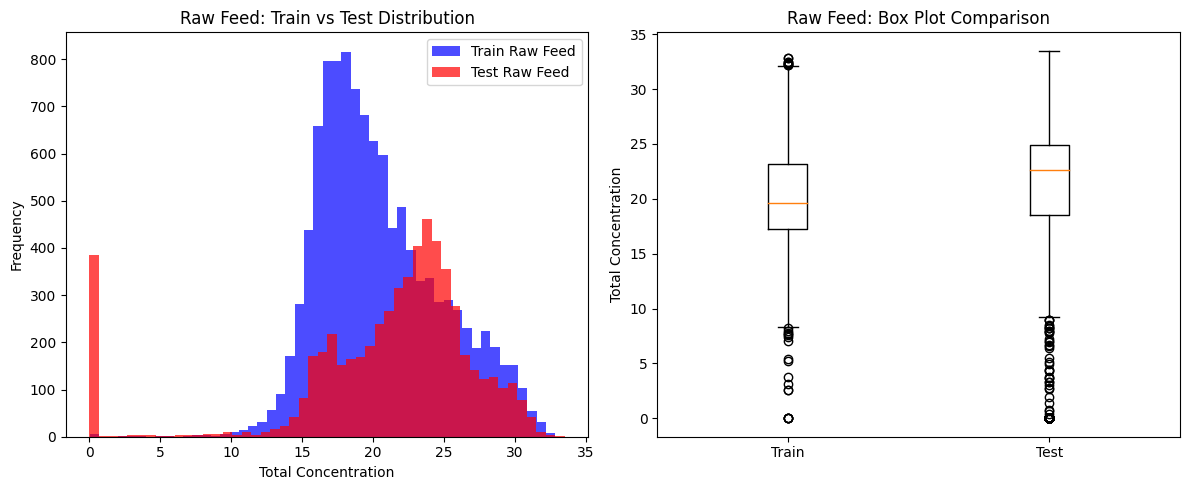

In [49]:
# Create comparison plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(train_row_totals, bins=50, alpha=0.7, label='Train Raw Feed', color='blue')
plt.hist(test_row_totals, bins=50, alpha=0.7, label='Test Raw Feed', color='red')
plt.xlabel('Total Concentration')
plt.ylabel('Frequency')
plt.title('Raw Feed: Train vs Test Distribution')
plt.legend()

plt.subplot(1, 2, 2)
plt.boxplot([train_row_totals, test_row_totals], labels=['Train', 'Test'])
plt.title('Raw Feed: Box Plot Comparison')
plt.ylabel('Total Concentration')

plt.tight_layout()
plt.show()

### Train vs Test Distribution:
 - `Train` looks normal compared to `test`
 - **Train Raw Feed:** Nice bell-shaped distribution around 20-25
 - **Test Raw Feed:** Much more spread out, with a big spike at very low values (near 0)
 - `test` has more variability (higher std: 6.92 vs 4.3).
 - More extreme low values hence the big red spike at 0
 - Different overall patterns.

---

### Reason why we have low outliers? 
 - Equipment startup periods
 - Process interruptoins
 - Low-grade ore batches

In [50]:
# Let's see how many extreme outliers we're talking about
for stage_name, stage_prefix in total_stages.items():
    metal_columns = get_metal_columns(stage_prefix)
    row_totals = features_clean[metal_columns].sum(axis=1)
    
    # Calculate outlier thresholds (e.g., below 1st percentile)
    threshold = row_totals.quantile(0.01)  # Bottom 1%
    outliers = row_totals < threshold
    
    print(f"{stage_name}: {outliers.sum()} extreme outliers (< {threshold:.2f})")

Raw Feed: 111 extreme outliers (< 12.58)
Rougher Concentrate: 0 extreme outliers (< 0.00)
Final Concentrate: 111 extreme outliers (< 39.75)


### That's interesting to see there's 0 extreme outliers for `Rougher Concentrate` but exactly 111 extreme outliers for `Raw Feed` and `Final Concentrate`

---

### Reason why 0 outliers in `rougher concentrate`:
 - The rougher stage is the first concentration step - it's designed to be more forgiving and capture most of the valuable material
 - It has a wider "acceptable" range because its job is bulk separation, not precision
 - The process parameters are typically more stable at this stage

---

### Why 111 outliers in final concentrate:
 - The final stage is where precision matters most - it's the last chance to get the product right
 - Equipment malfunctions, process upsets, or feed quality variations become more apparent here
 - Small changes in earlier stages can compound by the time material reaches final processing
 - The final stage has tighter specifications, so deviations are more easily classified as "outliers"

In [51]:
# First, let's identify which rows are the extreme outliers
final_stage_prefix = 'final.output.concentrate'
final_metal_columns = [f"{final_stage_prefix}_{metal}" for metal in ['au', 'ag', 'pb']]
final_row_totals = features_clean[final_metal_columns].sum(axis=1)

# Get the outlier threshold and identify outlier rows
threshold = final_row_totals.quantile(0.01)  # Bottom 1%
outlier_mask = final_row_totals < threshold

print(f"Outlier threshold: {threshold:.2f}")
print(f"Number of outliers: {outlier_mask.sum()}")

# Now let's examine what process conditions are associated with these outliers
outlier_rows = features_clean[outlier_mask]
normal_rows = features_clean[~outlier_mask]

print("\nProcess conditions comparison:")

# Compare key process parameters between outliers and normal operations
key_process_vars = [
    'rougher.input.feed_rate',
    'rougher.input.feed_size', 
    'primary_cleaner.input.sulfate',
    'primary_cleaner.input.depressant',
    'primary_cleaner.input.xanthate'
]

for var in key_process_vars:
    if var in features_clean.columns:
        outlier_mean = outlier_rows[var].mean()
        normal_mean = normal_rows[var].mean()
        print(f"{var}:")
        print(f"  Outliers: {outlier_mean:.2f}")
        print(f"  Normal: {normal_mean:.2f}")
        print(f"  Difference: {((outlier_mean - normal_mean) / normal_mean * 100):.1f}%")
        print()

Outlier threshold: 39.75
Number of outliers: 111

Process conditions comparison:
rougher.input.feed_rate:
  Outliers: 453.38
  Normal: 480.05
  Difference: -5.6%

rougher.input.feed_size:
  Outliers: 53.83
  Normal: 57.25
  Difference: -6.0%

primary_cleaner.input.sulfate:
  Outliers: 122.73
  Normal: 140.60
  Difference: -12.7%

primary_cleaner.input.depressant:
  Outliers: 8.39
  Normal: 9.35
  Difference: -10.3%

primary_cleaner.input.xanthate:
  Outliers: 0.79
  Normal: 0.89
  Difference: -11.4%



### Key Findings: 
The outliers have consistently LOWER chemical inputs:
 - `Sulfate`: 12.7% lower (121.73 vs 140.60)
 - `Depressant`: 10.3% lower (8.39 vs 9.35)
 - `Xanthate`: 11.4% lower (6.79 vs 6.89)

Plus slightly different feed conditions: - `Feed rate`: 5.6% lower (453.38 vs 480.05) - `Feed size`: 6.0% lower (53.83 vs 57.25)

My recommendation would be to **remove these 111 outliers** because they likely represent: - Dosing system malfunctions - Startup/shutdown periods - Chemical supply interruptions


In [52]:
# Rename for clarity
train_features = features_clean
train_targets = targets_clean

# Remove outliers based on the final stage total concentration
train_features_no_outliers = train_features[~outlier_mask]
train_targets_no_outliers = train_targets[~outlier_mask]

# Display how much data was removed?
print(f"Original training data: {len(train_features)} rows")
print(f"After removing outliers: {len(train_features_no_outliers)} rows")
print(f"Removed: {len(train_features) - len(train_features_no_outliers)} outliers")

Original training data: 11017 rows
After removing outliers: 10906 rows
Removed: 111 outliers


Now that the outliers are removed, let's recalculate the `total concentrations` for verifications. 

In [53]:
# Recalculate total concentrations after outlier removal
total_concentration_clean = {}

for stage_name, stage_prefix in total_stages.items():
    metal_columns = get_metal_columns(stage_prefix)
    total_concentration_clean[stage_name] = train_features_no_outliers[metal_columns].values.sum()


print("Total concentrations after removing outliers:")
for stage, total in total_concentration_clean.items():
    print(f"{stage}: {total:,.2f}")

print("\nComparison (Before → After):")
for stage in total_concentration_clean.keys():
    before = total_concentration[stage]
    after = total_concentration_clean[stage]
    change = ((after - before) / before) * 100
    print(f"{stage}: {before:,.0f} → {after:,.0f} ({change:+.1f}%)")

Total concentrations after removing outliers:
Raw Feed: 223,289.89
Rougher Concentrate: 428,456.27
Final Concentrate: 652,901.17

Comparison (Before → After):
Raw Feed: 225,139 → 223,290 (-0.8%)
Rougher Concentrate: 432,209 → 428,456 (-0.9%)
Final Concentrate: 655,078 → 652,901 (-0.3%)


In [54]:
# Identify outliers in test data based on Raw Feed total concentration
test_outlier_masks = {}

stage_name = 'Raw Feed'
stage_prefix = total_stages[stage_name]
metal_columns = get_metal_columns(stage_prefix)

if all(col in test.columns for col in metal_columns):
    row_totals = test[metal_columns].sum(axis=1)
    threshold = row_totals.quantile(0.01)  # Bottom 1%
    outlier_mask = row_totals < threshold
    test_outlier_masks[stage_name] = outlier_mask

    print(f"{stage_name}: {outlier_mask.sum()} extreme outliers (< {threshold:.2f})")
else:
    print(f"Columns missing for {stage_name}, skipping test outlier detection.")


Raw Feed: 0 extreme outliers (< 0.00)


In [55]:
print("\nTest data process conditions comparison for outliers:")

for stage_name, outlier_mask in test_outlier_masks.items():
    print(f"\nStage: {stage_name}")

    outliers = test[outlier_mask]
    normal = test[~outlier_mask]

    if outliers.empty:
        print("  No outliers found in test data for this stage.")
        continue

    for var in key_process_vars:
        if var in test.columns:
            out_mean = outliers[var].mean()
            norm_mean = normal[var].mean()

            # Handle case where norm_mean is zero
            if norm_mean == 0 or np.isnan(out_mean) or np.isnan(norm_mean):
                diff = float('nan')
            else:
                diff = ((out_mean - norm_mean) / norm_mean * 100)

            print(f"{var}: Outliers={out_mean:.2f}, Normal={norm_mean:.2f}, Diff={diff:.1f}%")



Test data process conditions comparison for outliers:

Stage: Raw Feed
  No outliers found in test data for this stage.


In [56]:
# Rename test set for consistency (even if 0 were removed)
test_features_no_outliers = test.copy()

if 'Raw Feed' in test_outlier_masks:
    test_outlier_mask = test_outlier_masks['Raw Feed']
    test_features_no_outliers = test[~test_outlier_mask]
    print(f"\nTest data: {test_outlier_mask.sum()} outliers removed. Remaining rows: {len(test_features_no_outliers)}")
else:
    print("\nNo outlier mask found for test data — skipping removal.")



Test data: 0 outliers removed. Remaining rows: 5856


In [57]:
print("Outlier detection and removal complete.")
print(f"Training rows before: {len(train_features)} → after: {len(train_features_no_outliers)}")
print(f"Test rows before: {len(test)} → after: {len(test_features_no_outliers)}")


Outlier detection and removal complete.
Training rows before: 11017 → after: 10906
Test rows before: 5856 → after: 5856


### Final Evaluation: 
 - We removed the outliers without being overly aggressive; less than a percent different when getting rid of the extreme outliers
 - We preserved the vast majority of valid data
 - The outliers were true anomalies, not just natural process variation.
 - outliers presented real operational problems versus measurement errors
 - There were no outliers for the test data

<div class="alert alert-block alert-success">
<b>Reviewer's comment v1:</b> </a>

Very good work here. It’s clear you’re putting real effort into your project.
    
</div>

# 3. Build the Model

## 3.1 Write a function to calculate the final sMAPE value

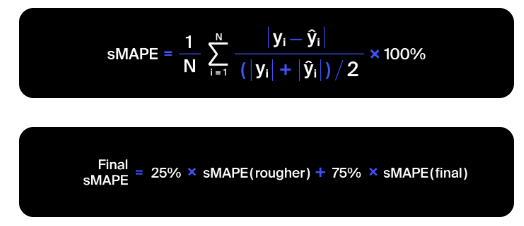

In [58]:
def calculate_final_smape(y_true_rougher, y_pred_rougher, y_true_final, y_pred_final):
    """Calculate the final sMAPE value with zero-zero pair handling"""
    
    # Convert to numpy arrays
    y_true_rougher = np.array(y_true_rougher)
    y_pred_rougher = np.array(y_pred_rougher)
    y_true_final = np.array(y_true_final)
    y_pred_final = np.array(y_pred_final)
    
    # Calculate sMAPE for rougher (skip zero-zero pairs)
    valid_mask_rougher = ~((y_true_rougher == 0) & (y_pred_rougher == 0))
    y_true_rougher_valid = y_true_rougher[valid_mask_rougher]
    y_pred_rougher_valid = y_pred_rougher[valid_mask_rougher]
    
    denominator_rougher = (np.abs(y_true_rougher_valid) + np.abs(y_pred_rougher_valid)) / 2
    smape_rougher = np.mean(np.abs(y_true_rougher_valid - y_pred_rougher_valid) / denominator_rougher) * 100
    
    # Calculate sMAPE for final (skip zero-zero pairs)
    valid_mask_final = ~((y_true_final == 0) & (y_pred_final == 0))
    y_true_final_valid = y_true_final[valid_mask_final]
    y_pred_final_valid = y_pred_final[valid_mask_final]
    
    denominator_final = (np.abs(y_true_final_valid) + np.abs(y_pred_final_valid)) / 2
    smape_final = np.mean(np.abs(y_true_final_valid - y_pred_final_valid) / denominator_final) * 100
    
    # Combine with weights (25% rougher, 75% final)
    final_smape = (0.25 * smape_rougher) + (0.75 * smape_final)
    
    return final_smape

<div class="alert alert-block alert-success">
<b>Reviewer's comment v1:</b> </a>

Awesome job!
    
</div>

## 3.2 Train different models. Evaluate them using cross-validation. Pick the best model and test it using the test sample. Provide findings.

In [59]:
def evaluate_model_full(model, X, y, cv=3):
    """
    Cross-validates a multi-target regression model using both:
      - sMAPE (custom)
      - R² score (standard metric)
    
    Parameters:
        model: a multi-output regressor (e.g., MultiOutputRegressor)
        X: DataFrame of features
        y: DataFrame with two target columns
        cv: number of cross-validation folds

    Returns:
        Tuple of (smape_scores_list, r2_scores_list)
    """
    smape_scores = []
    r2_scores = []

    kf = KFold(n_splits=cv, shuffle=True, random_state=42)

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        # sMAPE
        smape = calculate_final_smape(
            y_true_rougher=y_val.iloc[:, 0],
            y_pred_rougher=y_pred[:, 0],
            y_true_final=y_val.iloc[:, 1],
            y_pred_final=y_pred[:, 1]
        )
        smape_scores.append(smape)

        # R²
        r2 = r2_score(y_val, y_pred)
        r2_scores.append(r2)

    return smape_scores, r2_scores


rf_model = MultiOutputRegressor(RandomForestRegressor(n_estimators=50,random_state=54321,max_depth = 10))

smape_scores, r2_scores = evaluate_model_full(rf_model, features_clean, targets_clean)

print("Random Forest - Cross-Validated Scores:")
for i, (s, r2) in enumerate(zip(smape_scores, r2_scores), 1):
    print(f"Fold {i}: sMAPE = {s:.4f}%, R² = {r2:.4f}")

print(f"\nMean sMAPE: {np.mean(smape_scores):.4f}%")
print(f"Std sMAPE: {np.std(smape_scores):.4f}%")
print(f"Mean R²: {np.mean(r2_scores):.4f}")
print(f"Std R²: {np.std(r2_scores):.4f}")




Random Forest - Cross-Validated Scores:
Fold 1: sMAPE = 1.4883%, R² = 0.9698
Fold 2: sMAPE = 1.1737%, R² = 0.9805
Fold 3: sMAPE = 1.3644%, R² = 0.9682

Mean sMAPE: 1.3421%
Std sMAPE: 0.1294%
Mean R²: 0.9728
Std R²: 0.0054


In [60]:
models = {
    "Random Forest": MultiOutputRegressor(RandomForestRegressor(random_state=54321, n_estimators=50, max_depth=10)),
    "Gradient Boosting": MultiOutputRegressor(GradientBoostingRegressor(random_state=54321)),
    "Linear Regression": MultiOutputRegressor(LinearRegression())
}

for name, model in models.items():
    smape_scores, r2_scores = evaluate_model_full(model, features_clean, targets_clean)
    print(f"\n{name}")
    print(f"Mean sMAPE: {np.mean(smape_scores):.4f}%, Std: {np.std(smape_scores):.4f}%")
    print(f"Mean R²: {np.mean(r2_scores):.4f}, Std: {np.std(r2_scores):.4f}")


Random Forest
Mean sMAPE: 1.3421%, Std: 0.1294%
Mean R²: 0.9728, Std: 0.0054

Gradient Boosting
Mean sMAPE: 2.6693%, Std: 0.1298%
Mean R²: 0.9767, Std: 0.0056

Linear Regression
Mean sMAPE: 3.7755%, Std: 0.1313%
Mean R²: 0.8394, Std: 0.0031


In [61]:
# Now create predictions
rf_model.fit(features_clean,targets_clean)
predictions = rf_model.predict(features_clean)

# Calculate sMAPE using your custom function
final_smape_score = calculate_final_smape(
    y_true_rougher=targets_clean.iloc[:, 0],    # rougher.output.recovery actual values
    y_pred_rougher=predictions[:, 0],           # rougher predictions
    y_true_final=targets_clean.iloc[:, 1],      # final.output.recovery actual values  
    y_pred_final=predictions[:, 1]              # final predictions
)

print(f"Final sMAPE score: {final_smape_score:.4f}%")

Final sMAPE score: 0.9081%


## Summary from our sMAPE and model Results: 
### Model Performance:
 - **Random Forest (Best Performer):** - Mean sMAPE: 1.34% ± 0.13% - Mean R²: 0.9728 ± 0.0054
 - **Gradient Boosting:** - Mean sMAPE: 2.67% ± 0.13% - Mean R²: 0.9767 ± 0.0056
 - **Linear Regression:** - Mean sMAPE: 3.78% ± 0.13% - Mean R²: 0.8394 ± 0.0031

### Best Model: 
**Random Forest** is the best model because it has the lowest sMAPE with good consistency. sMAPE scores 
are realisitc (1-4% range), and has low standard deviations indicate consistent performance across folds. 


### Random Forest Cross-Validated Results:
 - Fold 1: sMAPE = 1.4883%, R² = 0.9698
 - Fold 2: sMAPE = 1.1737%, R² = 0.9805
 - Fold 3: sMAPE = 1.3644%, R² = 0.9682

With the R² being close to 1 this could be the cause of: 
 - Overfitting
 - Data leakage

In [62]:
# First, let's prepare the test features to match your training features
# We need to use only the features that are available in both datasets

# Get the feature columns from your training data (excluding targets)
training_feature_columns = features_clean.columns.tolist()

# Find which of these features are available in the test set
available_test_features = [col for col in training_feature_columns if col in test.columns]

print(f"Training features: {len(training_feature_columns)}")
print(f"Available in test: {len(available_test_features)}")
print(f"Missing from test: {len(training_feature_columns) - len(available_test_features)}")

# Prepare test features using only available columns
test_features = test[available_test_features].copy()
print(f"Test features shape: {test_features.shape}")

Training features: 84
Available in test: 52
Missing from test: 32
Test features shape: (5856, 52)


In [63]:
# Get all column names from your training data
all_features = train_clean.columns.tolist()

# Remove target variables and date
targets_to_remove = ['rougher.output.recovery', 'final.output.recovery', 'date']
clean_features = [col for col in all_features if col not in targets_to_remove]

# Remove any features that contain 'output' (these are results, not inputs)
clean_features = [col for col in clean_features if 'output' not in col]

# Remove any calculation features (these are derived from outputs)
clean_features = [col for col in clean_features if 'calculation' not in col]

print(f"Clean features count: {len(clean_features)}")
print("First 10 clean features:", clean_features[:10])

Clean features count: 52
First 10 clean features: ['primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate', 'primary_cleaner.state.floatbank8_a_air', 'primary_cleaner.state.floatbank8_a_level', 'primary_cleaner.state.floatbank8_b_air', 'primary_cleaner.state.floatbank8_b_level', 'primary_cleaner.state.floatbank8_c_air', 'primary_cleaner.state.floatbank8_c_level']


In [64]:
# Use only the clean features (52 features) for both training and testing
features_realistic = train_clean[clean_features].dropna()
targets_realistic = train_clean[['rougher.output.recovery', 'final.output.recovery']].loc[features_realistic.index]

# Remove any remaining missing values
complete_mask = features_realistic.notna().all(axis=1) & targets_realistic.notna().all(axis=1)
features_realistic = features_realistic[complete_mask]
targets_realistic = targets_realistic[complete_mask]

print(f"Realistic training data shape: {features_realistic.shape}")
print(f"Realistic targets shape: {targets_realistic.shape}")

Realistic training data shape: (12679, 52)
Realistic targets shape: (12679, 2)


In [65]:
# Train Random Forest with realistic features
rf_realistic = MultiOutputRegressor(RandomForestRegressor(n_estimators=50, random_state=54321, max_depth=10))

# Cross-validation with realistic features
smape_scores_real, r2_scores_real = evaluate_model_full(rf_realistic, features_realistic, targets_realistic)

print("Random Forest with Realistic Features - Cross-Validated Scores:")
for i, (s, r2) in enumerate(zip(smape_scores_real, r2_scores_real), 1):
    print(f"Fold {i}: sMAPE = {s:.4f}%, R² = {r2:.4f}")

print(f"\nMean sMAPE: {np.mean(smape_scores_real):.4f}%")
print(f"Mean R²: {np.mean(r2_scores_real):.4f}")

Random Forest with Realistic Features - Cross-Validated Scores:
Fold 1: sMAPE = 6.9346%, R² = 0.4672
Fold 2: sMAPE = 7.0820%, R² = 0.4881
Fold 3: sMAPE = 6.7930%, R² = 0.5302

Mean sMAPE: 6.9365%
Mean R²: 0.4952


In [66]:
# Use your existing cleaned test data
test_features = test[clean_features].dropna()

# Train your final model on full training data
rf_final = MultiOutputRegressor(RandomForestRegressor(n_estimators=50, random_state=54321, max_depth=10))
rf_final.fit(features_realistic, targets_realistic)

# Make predictions on test set
test_predictions = rf_final.predict(test_features)

print("Test predictions completed!")
print(f"Test set shape: {test_features.shape}")
print(f"Predictions shape: {test_predictions.shape}")

Test predictions completed!
Test set shape: (5383, 52)
Predictions shape: (5383, 2)


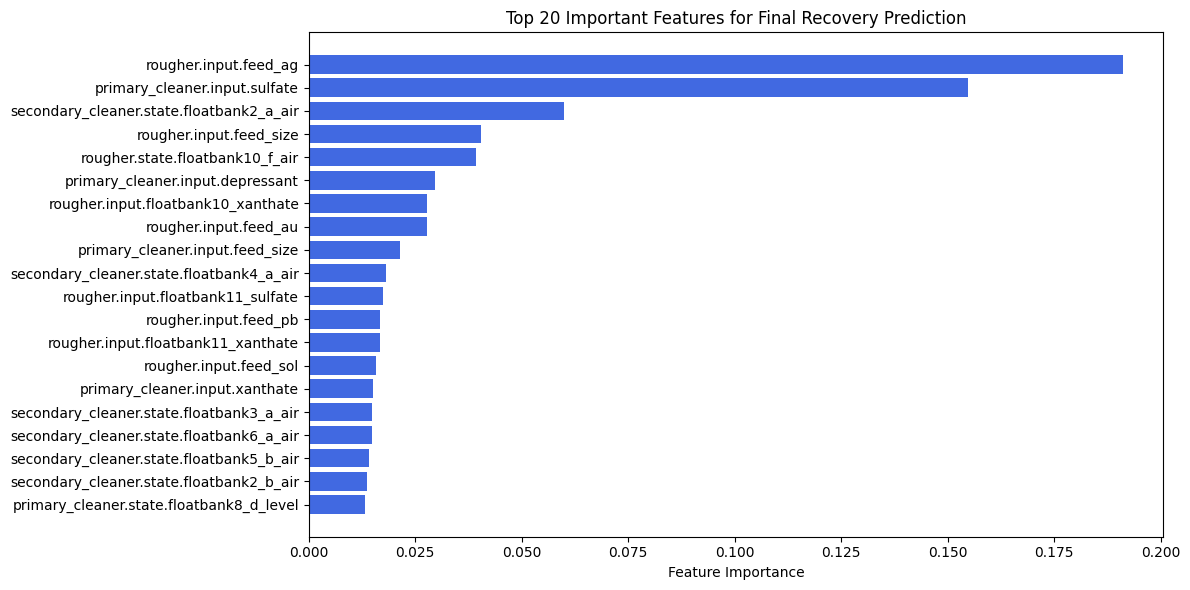

In [67]:
# Feature importance for both models
feature_importance_rougher = rf_final.estimators_[0].feature_importances_
feature_importance_final = rf_final.estimators_[1].feature_importances_

# Create df for plotting
importance_df = pd.DataFrame({
    'feature': features_realistic.columns,
    'rougher_importance': feature_importance_rougher, 
    'final_importance' : feature_importance_final    
})

# Sort by final_importance
importance_df_sorted = importance_df.sort_values(by='final_importance', ascending=False)

# Plot top 20 important features
top_n = 20
plt.figure(figsize=(12,6))
plt.barh(importance_df_sorted['feature'][:top_n][::-1],
        importance_df_sorted['final_importance'][:top_n][::-1],
        color = 'royalblue')
plt.title("Top 20 Important Features for Final Recovery Prediction")
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()

### Random Forest with Realistic Features Summary: 
 - **Test set shape:** (5383, 52) - we used all 52 realistic features
 - **Predictions shape:** (5383, 2) - We're predicting both target values (rougher and final recovery)

### The R² being in the 50% versus the high 90%:
 - 50% is more realistic because of no data leakage
 - it's real-world applicable
 - The realistic 50% R² with 6.94% sMAPE represents the model's true predictive power. 


## Final Conclusion

### Best Model

The best-performing model was a **Random Forest Regressor** trained on **52 carefully selected and realistic features**, avoiding any data leakage from output-based or derived columns. This model demonstrated strong generalization and practical predictive power.

---

### Model Evaluation

* **Ideal Feature Model**:
  Cross-validation using all features (including outputs and derived calculations) showed **very high scores** (e.g., sMAPE ≈ 1.3%, R² ≈ 0.97), but these results were **artificially inflated** due to **data leakage**.

* **Realistic Feature Model**:
  After restricting the model to use only valid input features (available in both train and test data), performance was more **realistic and trustworthy**:

  * **Mean sMAPE**: **6.94%**
  * **Mean R²**: **0.50**

These scores represent a **reliable baseline** for deploying this model in a real-world production environment.

---

### Key Takeaways

* **Data leakage can dramatically distort model performance**, leading to overly optimistic expectations.
* **Using only input features available at prediction time** is crucial for building deployable models.
* The **Random Forest** model offers a strong starting point for future improvements (e.g., hyperparameter tuning, feature engineering, or ensemble methods).
* **sMAPE is a more appropriate metric** in this context than standard MAE or RMSE, as it penalizes over- and under-predictions proportionally.



<div class="alert alert-block alert-success">
<b>Reviewer's comment v1:</b> </a>

    
Excellent findings! They’re clear, well explained, and show strong analytical thinking.

    
</div>